# Import libraries

In [1]:
# Scientific libraries

import numpy as np
import math

# Visualization Libraries

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data analysis and ML libraries

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss,TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

###
#from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

###
from functions import my_scaler, OrdinalStandardScaler, evaluate_model, AUC_study

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import training and test sets after feature selection

In [3]:
X_train = pd.read_csv('Data/training_features.csv')
y_train = pd.read_csv('Data/training_target.csv')
X_test = pd.read_csv('Data/test_features.csv')
y_test = pd.read_csv('Data/test_target.csv')

NOTE: We split our data always before doing any manipulation to the data, like Resampling. Also, we resample **only** the training set to avoid possible data leakage in the test set

## Resample

- We consider a hybrid sampling method: BordelineSMOTE
- Let's see how it works
- Later, we will include the sampling in a pipeline 

In [4]:
bl_smote = BorderlineSMOTE(random_state=42)
X_train_bl, y_train_bl = bl_smote.fit_resample(X_train, y_train)
print("X_train_hybrid shape:", X_train_bl.shape)
X_train_bl.head()

X_train_hybrid shape: (311002, 7)


,High_BP,General_health,High_Chol,BMI,Age,Physical_activity,Difficulty_walking
0,1,2,0,26,7,1,0
1,1,3,1,34,10,1,0
2,0,2,1,24,10,1,0
3,0,2,1,22,13,1,0
4,1,4,0,30,7,1,1


In [5]:
### Check the value counts
y_train_bl.value_counts()

Diabetes_status
0                  155501
1                  155501
dtype: int64

In [6]:
## We identify the Ordinal features or the model (the rest are binary)

In [7]:
X_train.nunique().sort_values()
ordinal_features = [col for col in X_train.columns if X_train[col].nunique()!=2]
ordinal_features

['General_health', 'BMI', 'Age']

# Build Model

## Baseline

### Random Forest with balanced class weight!

Classification report for training data
              precision    recall  f1-score   support

           0       0.94      0.69      0.80    155501
           1       0.31      0.76      0.44     28078

    accuracy                           0.70    183579
   macro avg       0.62      0.73      0.62    183579
weighted avg       0.84      0.70      0.74    183579

Classification report for test data
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     38876
           1       0.31      0.77      0.44      7019

    accuracy                           0.70     45895
   macro avg       0.63      0.73      0.62     45895
weighted avg       0.85      0.70      0.74     45895

Confusion matrix for test set


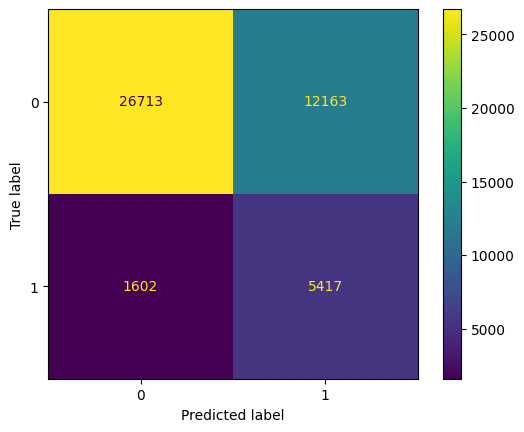

In [8]:
# Random Forest
RF_balanced = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42,class_weight='balanced')

evaluate_model(RF_balanced, X_train, y_train, X_test, y_test)

## Iteratemax

We will tune hyperparameters for 3 models:

- Logistic Regression
- Random Forest 
- Gradient Boosting

### Hyperparameter-tuning: Logistic Regression

In [9]:
# Model pipeline: Hybrid resampling, Scaling for only ordinal variables, Model
LR_pipeline = make_pipeline(
    BorderlineSMOTE(random_state=42),
    OrdinalStandardScaler(ordinal_features),
    LogisticRegression()
)

# Parameters for the grid Search

LR_params = {
    "logisticregression__max_iter": range(100,501,100),    
    "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "logisticregression__penalty": ['l2'],
    "logisticregression__C": [1.0, 0.1, 0.01]
}

#scorer
f1 = make_scorer(f1_score)

LR_grid = GridSearchCV(
    LR_pipeline,
    param_grid=LR_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=f1
)

In [10]:
#### add values.ravel() to avoid warning.... issue with the GridSearchCV
LR_grid.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('borderlinesmote',
                                        BorderlineSMOTE(random_state=42)),
                                       ('ordinalstandardscaler',
                                        OrdinalStandardScaler(ordinal_features=['General_health',
                                                                                'BMI',
                                                                                'Age'])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.1, 0.01],
                         'logisticregression__max_iter': range(100, 501, 100),
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear']},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [11]:
# Best parameters

print("The parameters of the best model are:", LR_grid.best_params_)
print("The best F1-score is:", LR_grid.best_score_)

The parameters of the best model are: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
The best F1-score is: 0.43818386432297585


Classification report for training data
              precision    recall  f1-score   support

           0       0.94      0.69      0.80    155501
           1       0.31      0.76      0.44     28078

    accuracy                           0.70    183579
   macro avg       0.62      0.73      0.62    183579
weighted avg       0.84      0.70      0.74    183579

Classification report for test data
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     38876
           1       0.31      0.77      0.44      7019

    accuracy                           0.70     45895
   macro avg       0.62      0.73      0.62     45895
weighted avg       0.85      0.70      0.74     45895

Confusion matrix for test set


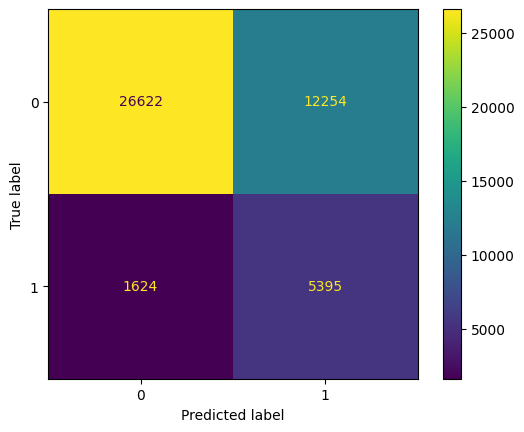

In [12]:
#Evaluete the best model

best_LR = LR_grid.best_estimator_
evaluate_model(best_LR,X_train,y_train,X_test,y_test)

### Hyperparameter-tuning: Random Forest

In [13]:
# Model pipeline: Hybrid resampling, Scaling for only ordinal variables, Model
RF_pipeline = make_pipeline(
    BorderlineSMOTE(random_state=42),
    OrdinalStandardScaler(ordinal_features),
    RandomForestClassifier(random_state=42)
)

# Parameters for the grid Search

RF_params = {
    "randomforestclassifier__n_estimators": range(25,101,25),
    "randomforestclassifier__max_depth": range(5,21,5)
}

#scorer
f1 = make_scorer(f1_score)

RF_grid = GridSearchCV(
    RF_pipeline,
    param_grid=RF_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=f1
)

In [14]:
#### add values.ravel() to avoid warning.... issue with the GridSearchCV
RF_grid.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('borderlinesmote',
                                        BorderlineSMOTE(random_state=42)),
                                       ('ordinalstandardscaler',
                                        OrdinalStandardScaler(ordinal_features=['General_health',
                                                                                'BMI',
                                                                                'Age'])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 21, 5),
                         'randomforestclassifier__n_estimators': range(25, 101, 25)},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [15]:
# Best parameters

print("The parameters of the best model are:", RF_grid.best_params_)
print("The best F1-score is:", RF_grid.best_score_)

The parameters of the best model are: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 50}
The best F1-score is: 0.43202787609822907


Classification report for training data
              precision    recall  f1-score   support

           0       0.95      0.66      0.78    155501
           1       0.30      0.82      0.44     28078

    accuracy                           0.68    183579
   macro avg       0.63      0.74      0.61    183579
weighted avg       0.85      0.68      0.73    183579

Classification report for test data
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     38876
           1       0.30      0.81      0.43      7019

    accuracy                           0.68     45895
   macro avg       0.62      0.73      0.60     45895
weighted avg       0.85      0.68      0.72     45895

Confusion matrix for test set


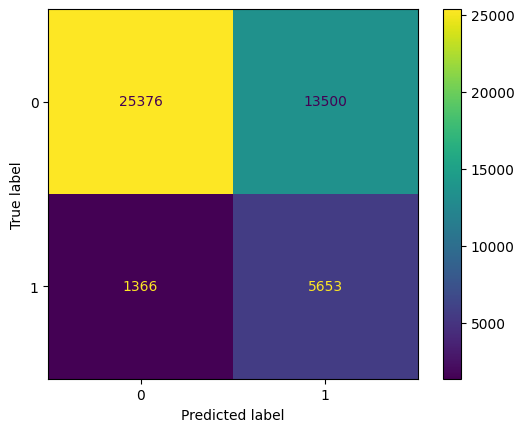

In [16]:
#Evaluate the best model

best_RF = RF_grid.best_estimator_
evaluate_model(best_RF,X_train, y_train, X_test,y_test)

### Hyperparameter-tuning: Gradient Boosting

In [24]:
# Model pipeline: Hybrid resampling, Scaling for only ordinal variables, Model
gb_pipeline = make_pipeline(
    BorderlineSMOTE(random_state=42),
    OrdinalStandardScaler(ordinal_features),
    GradientBoostingClassifier()
)

# Parameters for the grid Search

gb_params = {
    "gradientboostingclassifier__n_estimators": range(5,31,5),
    "gradientboostingclassifier__max_depth": range(2,6)
}

#scorer
f1 = make_scorer(f1_score)

gb_grid = GridSearchCV(
    gb_pipeline,
    param_grid=gb_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=f1
)

In [25]:
#### add values.ravel() to avoid warning.... issue with the GridSearchCV
gb_grid.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('borderlinesmote',
                                        BorderlineSMOTE(random_state=42)),
                                       ('ordinalstandardscaler',
                                        OrdinalStandardScaler(ordinal_features=['General_health',
                                                                                'BMI',
                                                                                'Age'])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 6),
                         'gradientboostingclassifier__n_estimators': range(5, 31, 5)},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [26]:
# Best parameters

print("The parameters of the best model are:", gb_grid.best_params_)
print("The best F1-score is:", gb_grid.best_score_)

The parameters of the best model are: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 30}
The best F1-score is: 0.4327281682539553


Classification report for training data
              precision    recall  f1-score   support

           0       0.95      0.66      0.78    155501
           1       0.30      0.80      0.43     28078

    accuracy                           0.68    183579
   macro avg       0.62      0.73      0.61    183579
weighted avg       0.85      0.68      0.73    183579

Classification report for test data
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     38876
           1       0.30      0.81      0.44      7019

    accuracy                           0.68     45895
   macro avg       0.62      0.73      0.61     45895
weighted avg       0.85      0.68      0.73     45895

Confusion matrix for test set


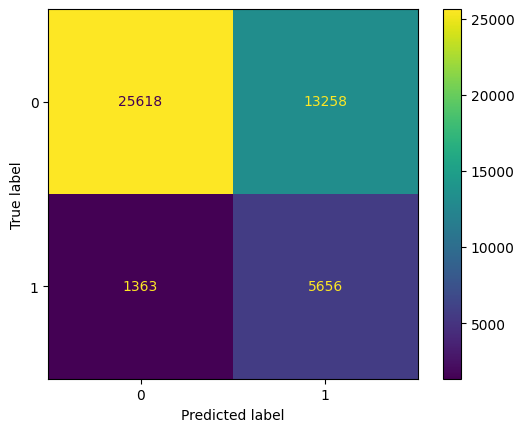

In [28]:
best_gb = gb_grid.best_estimator_
evaluate_model(best_gb,X_train,y_train,X_test,y_test)

After hyperparameter tuning:

- LR → Recall= 0.77 F1= 0.44
- RF → Recall= 0.81 F1= 0.43
- GB → Recall= 0.81 F1= 0.44

Therefore, we will continue with the Gradient Boosting Classifier.

## Play with the threshold

Now, we will focus on the Gradient boosting Classifier with the best parameter set. 

- First, we will use the AUC_study function to see the TPR vs FPR curve. This function also gives the optimal threshold.
- Second, we train the model using different thresholds.

The optimal threshold to minimize the fpr and maximize the tpr is: 0.5608024247402831
The false positive rate at the opt threshold: 0.2809959872414857
The true positive rate at the opt threshold: 0.7459752101438951


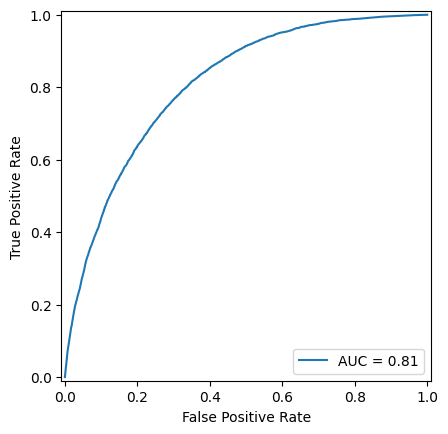

In [29]:
AUC_study(best_gb, X_test, y_test)

### Best Gradient Boosting Classifier with optimal threshold

Classification report for training data
              precision    recall  f1-score   support

           0       0.94      0.72      0.82    155501
           1       0.33      0.74      0.45     28078

    accuracy                           0.73    183579
   macro avg       0.63      0.73      0.63    183579
weighted avg       0.85      0.73      0.76    183579

Classification report for test data
              precision    recall  f1-score   support

           0       0.94      0.72      0.81     38876
           1       0.32      0.75      0.45      7019

    accuracy                           0.72     45895
   macro avg       0.63      0.73      0.63     45895
weighted avg       0.85      0.72      0.76     45895

Confusion matrix for test set


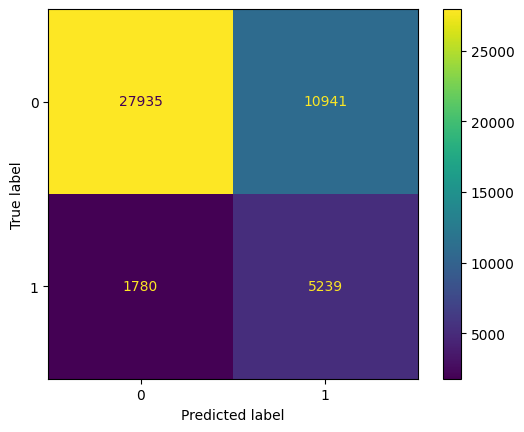

In [30]:
from sklearn.model_selection import FixedThresholdClassifier

gb_opt_thr = FixedThresholdClassifier(best_gb, threshold=0.56, response_method="predict_proba"
).fit(X_train, y_train)

evaluate_model(gb_opt_thr,X_train,y_train,X_test,y_test)
#print(classification_report(y_test,model_other_threshold.predict(X_test)))

Gradient Boosting Classifier (best hyperparameters):

- Default Threshold (0.5) → Recall= 0.81 F1= 0.44
- Optimal Threshold (0.56)→ Recall= 0.75 F1= 0.45

Even changing the threshold to its optimal value, F1 improves from 0.44 to 0.45
Then, for our app we will work with the Gradient Boosting Classifier with the default threshold

In [31]:
import joblib
joblib.dump(gb_grid.best_estimator_, 'model_deploy.pkl')

['model_deploy.pkl']

# Concluding remaks

REMARKS: We have tried to train models considering balanced data (either the parameter class_weight is balanced or we resample)

- Training a model either with all the features or with feature selection we get a recall of ~ 0.75 and F1 ~ 0.45
- After performing hyperparameter tuning, we still get a recall ~ 0.75 and F1 ~ 0.45
- We need to consider new features: either build features with the existing ones or include new features in the data.
- Hopefully, these new features can help the model training to better identify the cases near the threshold

**CONCLUSION**

- For now, we keep our study as this
- Despite having a relatively low F1-score, we get a recall of 0.81 → Of every 20 positive cases our model identifies correctly, 16 of them.
- We still have a relatively high rate for false positives, but for this case every false positive is not as expensive as a false negative: the diagnosis can be confirmed with some lab tests.
- The model needs other features that help it to minimize the number of false positives.
 
**IDEA**: do some more research in the medical field.

**Possible improvement in the data**

I believe this survey needs to include other features, such as:

- high triglycerides' history (would help to diagnose metabolic syndrome, which a risk factor for diabetes)
- family history of diabetes
- some other ones

 

In [33]:
X_train.columns

Index(['High_BP', 'General_health', 'High_Chol', 'BMI', 'Age',
       'Physical_activity', 'Difficulty_walking'],
      dtype='object')